<a href="https://colab.research.google.com/github/windyrahayu45/proyek-akhir/blob/main/Jaya_Jaya_Institute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Akhir: Menyelesaikan Permasalahan Jaya Jaya Institute


Nama: Windi Sri Rahayu

Email: Windyrahayu45@gmail.com

Id Dicoding:ayuuwindii


# **Persiapan**

## **Menyiapkan library yang dibutuhkan**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,recall_score
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import product
import pickle
import json

# **Menyiapkan data yang akan digunakan**

**Data Understanding**

In [3]:
# Baca data dengan separator ';'
data = pd.read_csv('data.csv', sep=';')

# Standardisasi nama kolom: lowercase dan ganti spasi ke underscore
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

# Cek ulang kolom setelah diperbaiki
print(data.columns.tolist())
data.info()



['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nacionality', 'mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation', 'admission_grade', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations', 'unemployment_rate', 'inflation_rate', 'gdp', 'status']
<class 'pandas.core.frame.DataFrame'>
Range

In [4]:
# Hapus duplikat
data = data.drop_duplicates()

# Ubah kolom-kolom numerik
kolom_numerik = [
    'previous_qualification_grade',
    'admission_grade',
    'curricular_units_1st_sem_grade',
    'curricular_units_2nd_sem_grade',
    'unemployment_rate',
    'gdp'
]

for kolom in kolom_numerik:
    if kolom in data.columns:
        data[kolom] = pd.to_numeric(data[kolom], errors='coerce')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   marital_status                                4424 non-null   int64  
 1   application_mode                              4424 non-null   int64  
 2   application_order                             4424 non-null   int64  
 3   course                                        4424 non-null   int64  
 4   daytime_evening_attendance                    4424 non-null   int64  
 5   previous_qualification                        4424 non-null   int64  
 6   previous_qualification_grade                  4424 non-null   float64
 7   nacionality                                   4424 non-null   int64  
 8   mothers_qualification                         4424 non-null   int64  
 9   fathers_qualification                         4424 non-null   i

In [5]:
# Cek missing values
missing = data.isnull().sum()
print("Missing Values:\n", missing)


Missing Values:
 marital_status                                  0
application_mode                                0
application_order                               0
course                                          0
daytime_evening_attendance                      0
previous_qualification                          0
previous_qualification_grade                    0
nacionality                                     0
mothers_qualification                           0
fathers_qualification                           0
mothers_occupation                              0
fathers_occupation                              0
admission_grade                                 0
displaced                                       0
educational_special_needs                       0
debtor                                          0
tuition_fees_up_to_date                         0
gender                                          0
scholarship_holder                              0
age_at_enrollment                

**Data Preparation**

In [6]:
# Deteksi Outlier di kolom numerik pakai IQR method
for kolom in kolom_numerik:
    if kolom in data.columns:
        Q1 = data[kolom].quantile(0.25)
        Q3 = data[kolom].quantile(0.75)
        IQR = Q3 - Q1
        batas_bawah = Q1 - 1.5 * IQR
        batas_atas = Q3 + 1.5 * IQR

        # Hapus outlier
        data = data[(data[kolom] >= batas_bawah) & (data[kolom] <= batas_atas)]

#  Reset index setelah pembersihan
data.reset_index(drop=True, inplace=True)

#  Cek hasil akhir
print("Data setelah cleaning:")
print(data.info())

# (Optional) Simpan hasil ke file baru
data.to_csv('data_cleaned.csv', index=False)

Data setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   marital_status                                3285 non-null   int64  
 1   application_mode                              3285 non-null   int64  
 2   application_order                             3285 non-null   int64  
 3   course                                        3285 non-null   int64  
 4   daytime_evening_attendance                    3285 non-null   int64  
 5   previous_qualification                        3285 non-null   int64  
 6   previous_qualification_grade                  3285 non-null   float64
 7   nacionality                                   3285 non-null   int64  
 8   mothers_qualification                         3285 non-null   int64  
 9   fathers_qualification                   

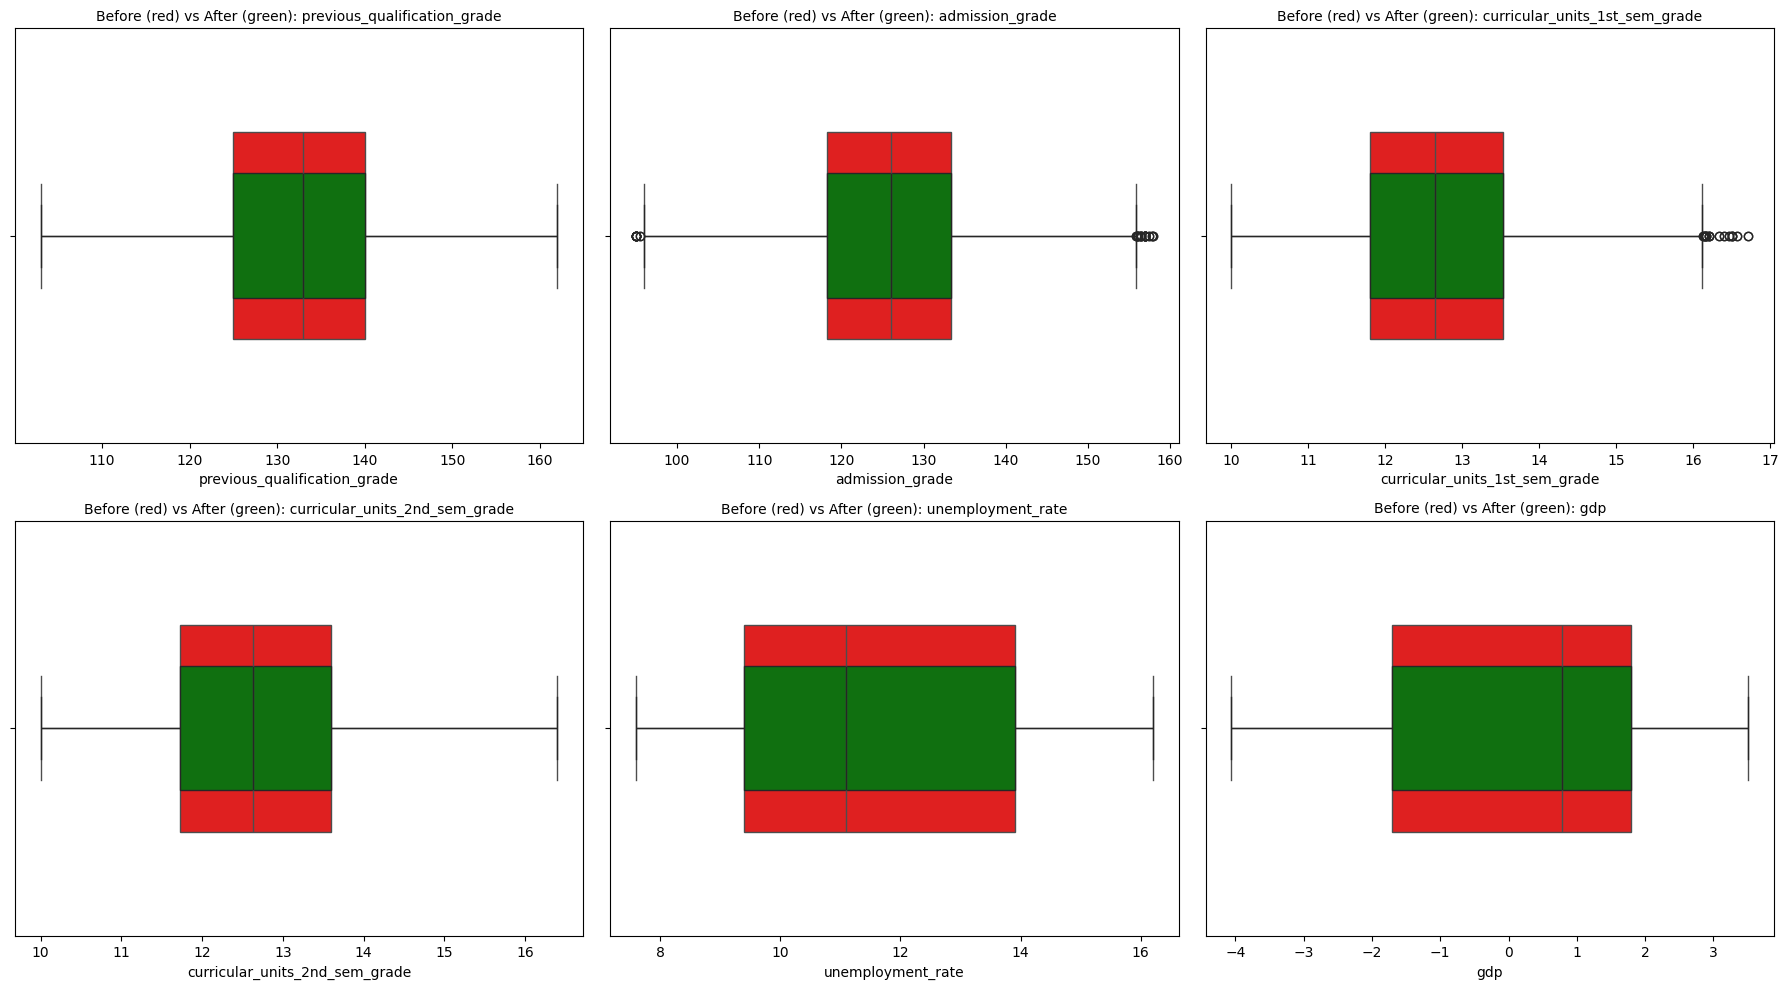

In [7]:
# data yang sudah dibersihkan
cleaned_data = pd.read_csv('data_cleaned.csv')
# Visualisasi: Boxplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for idx, kolom in enumerate(kolom_numerik):
    if kolom in data.columns and kolom in cleaned_data.columns:
        sns.boxplot(x=data[kolom], color="red", ax=axes[idx], width=0.5)
        sns.boxplot(x=cleaned_data[kolom], color="green", ax=axes[idx], width=0.3)
        axes[idx].set_title(f'Before (red) vs After (green): {kolom}', fontsize=10)

plt.tight_layout()
plt.show()

**Modeling**

In [21]:
X = cleaned_data.drop('status', axis=1)  # Ganti 'Target' sesuai nama kolom label kamu
y = cleaned_data['status']

# Mapping label (string -> angka)
label_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
y = y.map(label_mapping)

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Imbalance with SMOTE
print("\n=== SMOTE Resampling ===")
print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_resampled))

#  Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

print("\n=== GridSearchCV Results ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy (tuned RF): {grid_search.best_score_}")

# Evaluate Tuned RF on Test Set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n=== Test Set Evaluation ===")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#  Predict Probabilities for Threshold Tuning
y_probs = best_rf.predict_proba(X_test)

#  Threshold Tuning
print("\n=== Threshold Tuning ===")
dropout_thresholds = np.arange(0.3, 0.6, 0.05)   # Range: 0.30 - 0.55
enrolled_thresholds = np.arange(0.3, 0.6, 0.05)  # Range: 0.30 - 0.55

best_score = 0
best_thresholds = (0.5, 0.5)
best_preds = None

for dt, et in product(dropout_thresholds, enrolled_thresholds):
    y_pred_custom = []
    for probs in y_probs:
        if probs[0] >= dt:
            y_pred_custom.append(0)  # Dropout
        elif probs[1] >= et:
            y_pred_custom.append(1)  # Enrolled
        else:
            y_pred_custom.append(2)  # Graduate
    y_pred_custom = np.array(y_pred_custom)

    macro_recall = recall_score(y_test, y_pred_custom, average='macro')

    if macro_recall > best_score:
        best_score = macro_recall
        best_thresholds = (dt, et)
        best_preds = y_pred_custom

#  Final Evaluation with Best Thresholds
print("\n=== Best Thresholds Found ===")
print(f"Dropout Threshold: {best_thresholds[0]}")
print(f"Enrolled Threshold: {best_thresholds[1]}")
print(f"Macro Recall: {best_score:.4f}")

print("\n=== Final Classification Report ===")
print(classification_report(y_test, best_preds, target_names=['Dropout', 'Enrolled', 'Graduate']))

print("\n=== Final Confusion Matrix ===")
print(confusion_matrix(y_test, best_preds))


with open('model_rf.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

with open('thresholds.json', 'w') as f:
    json.dump({'dropout_threshold': best_thresholds[0], 'enrolled_threshold': best_thresholds[1]}, f)


=== SMOTE Resampling ===
Before SMOTE: Counter({2: 1587, 1: 534, 0: 507})
After SMOTE: Counter({0: 1587, 2: 1587, 1: 1587})
Fitting 3 folds for each of 72 candidates, totalling 216 fits

=== GridSearchCV Results ===
Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy (tuned RF): 0.8443604284814116

=== Test Set Evaluation ===
              precision    recall  f1-score   support

     Dropout       0.69      0.54      0.60       127
    Enrolled       0.40      0.46      0.43       134
    Graduate       0.84      0.86      0.85       396

    accuracy                           0.71       657
   macro avg       0.64      0.62      0.63       657
weighted avg       0.72      0.71      0.71       657

Confusion Matrix:
[[ 68  40  19]
 [ 26  61  47]
 [  5  51 340]]

=== Threshold Tuning ===

=== Best Thresholds Found ===
Dropout Threshold: 0.39999999999999997
Enrolled Threshold

**Evaluasi**

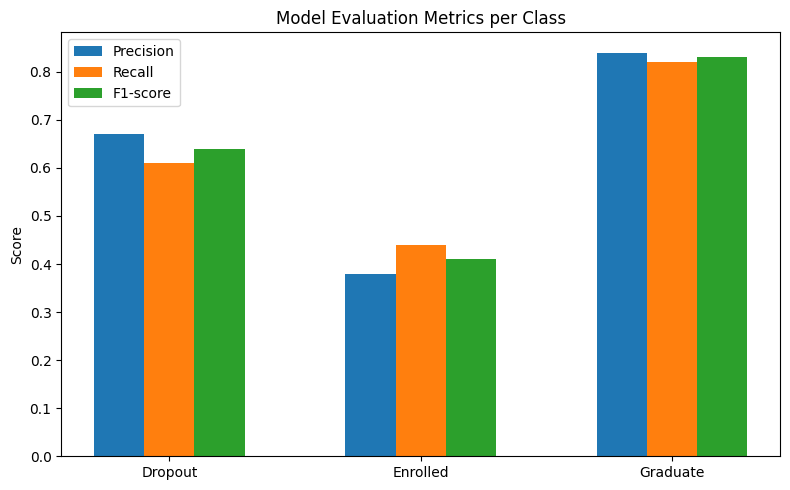

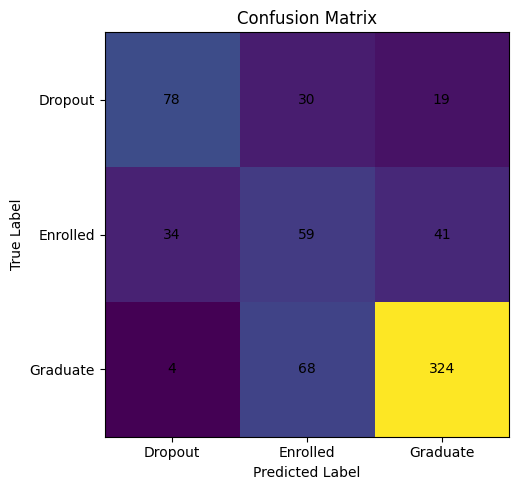

In [14]:
# Simplified evaluation metrics from the final model
classes = ['Dropout', 'Enrolled', 'Graduate']
precision = [0.67, 0.38, 0.84]
recall    = [0.61, 0.44, 0.82]
f1_score  = [0.64, 0.41, 0.83]

# Bar chart for Precision, Recall, and F1-score
x = np.arange(len(classes))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width)
plt.bar(x, recall, width)
plt.bar(x + width, f1_score, width)
plt.xticks(x, classes)
plt.ylabel('Score')
plt.title('Model Evaluation Metrics per Class')
plt.legend(['Precision', 'Recall', 'F1-score'])
plt.tight_layout()
plt.show()

# Confusion matrix
cm = np.array([[78, 30, 19],
               [34, 59, 41],
               [4,  68, 324]])

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(x, classes)
plt.yticks(x, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

Berdasarkan hasil evaluasi model Random Forest dengan SMOTE dan threshold tuning, diperoleh:

- **Akurasi keseluruhan**: sekitar **70–71%** pada data uji.  
- **Macro Recall**: **0.62**, menandakan rata‐rata sensitivity ketiga kelas.

| Kelas      | Precision | Recall (sebelum → sesudah) | F1-Score |
|------------|-----------|-----------------------------|----------|
| **Dropout**   | 0.69 → 0.67  | 0.54 → 0.61               | 0.60 → 0.64  |
| **Enrolled**  | 0.40 → 0.38  | 0.46 → 0.44               | 0.43 → 0.41  |
| **Graduate**  | 0.84 → 0.84  | 0.86 → 0.82               | 0.85 → 0.83  |

- **Recall “Dropout” meningkat** dari 54% → 61% setelah threshold tuning, artinya model kini lebih berhasil mendeteksi mahasiswa yang berpotensi keluar.  
- **Recall “Enrolled”** relatif stabil di sekitar 44%.  
- **Recall “Graduate”** turun sedikit dari 86% → 82%, namun tetap tinggi.




=== Top 10 Fitur Terpenting ===
                                 feature  importance
30     curricular_units_2nd_sem_approved    0.104900
24     curricular_units_1st_sem_approved    0.076460
16               tuition_fees_up_to_date    0.067896
31        curricular_units_2nd_sem_grade    0.055723
25        curricular_units_1st_sem_grade    0.052895
12                       admission_grade    0.044290
6           previous_qualification_grade    0.042594
3                                 course    0.038730
29  curricular_units_2nd_sem_evaluations    0.038275
35                                   gdp    0.037837


<ipython-input-16-4f762ad3c65e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


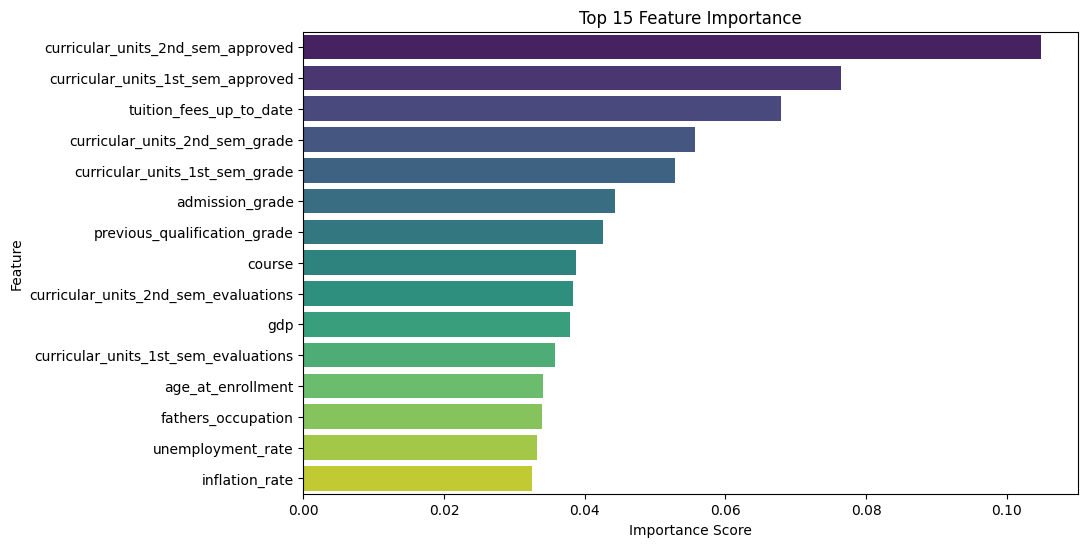

In [16]:
# 11. Feature Importance
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Buat dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Tampilkan 10 fitur terpenting
print("\n=== Top 10 Fitur Terpenting ===")
print(feature_importance_df.head(10))

# 12. Visualisasi Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**Interpretasi**
Curricular units (1st & 2nd sem)  itu sangat dominan dimana prestasi akademik per semester menjadi penentu utama.

Tuition fees up to date juga penting karena
kalau nunggak SPP, cenderung lebih besar peluang dropout.

Admission grade dan previous qualification grade juga relevan:
nilai saat masuk kampus dan nilai pendidikan sebelumnya berpengaruh.

Course dan GDP  juga memengaruhi:
mungkin beberapa jurusan lebih berat, atau ekonomi nasional berdampak pada dropout.